# SIT744 Deep Learning
## (Assignment-2)

**Assignment objective:** This assignment is to feedback on your learning in deep learning theory and its application to  data analytics or artificial intelligence problems.  

It builds on Assignment 1 but requires a higher level of mastery of deep learning theory and programming/engineering skills. In particular, you will practice making design decisions yourself. You are also likely to encounter practical issues that will help you consolidate textbook learning. 

* Name: Rahul Kumar
* Student ID: 221045868
* E-mail: krahul@deakin.edu.au

## **Task 1 (P Task) Smart Recycling using Deep Learning**


### Task 1.1 Define a problem 


Waste is a critical worldwide issue. Expanding volumes of waste are being produced as the worldwide populace and expectations for everyday comforts rise. Individuals are progressively worried about the production of waste and its impact, and are looking for ways of managing the issue.

Recycling is the process of converting waste materials into new materials and items. The recuperation of energy from waste materials is in many cases included in this concept. The recyclability of a material relies upon its capacity to reacquire the properties it had in its original state. It is an option to "conventional" waste removal that can save material and assist with bringing down greenhouse gas emissions. Recycling can forestall the waste of possibly valuable materials and diminish the utilization of fresh raw materials, in this way decreasing: energy use, air pollution (from incineration), and water pollution (from landfilling).

The purpose of this assignment is to build a real time application which recognizes the type of waste (Recyclable or Organic) and categorize it into defined categories. By implementing this intelligent Image classification system ,we  want to reduce the physical  efforts and effectively segregate the waste into different categories. We'll be using a dataset consisting of Recyclable & Organic objects for training (as input) & evaluation of our model.  

### Task 1.2 Make a plan

After thorough research, we have used 'Waste Classification data' dataset from Kaggle to develop a deep learning solution. The model used is 'Convolution Neural Network (CNN)', a  Machine Learning algorithm which is used on a dataset containing images of garbage. The aim of using a Convolutional Network to process an image resides in its ability to extract certain patterns or features from images with an invariance in position, rotation, and scale. The structure of CNN usually consists of three types of layers: convolutional, pool, and fully connected. Convolutional and pool layers are stacked one after the other. 

We have trained the dataset using 'VGG16 model' via using 'Transfer Learning technique' of CNN for classification in which we take an existing model which is trained on far more data and use the features that the model learned from that data and use it for our problem. Since that model has learned from a lot of data so that model has been trained quite well to find some features. We can use those features and by tweaking some part of that trained model use it for our use case. In transfer learning instead of training all the layers of the model we lock some of the layers and use those trained weights in the locked layers to extract particular features from our data. We don’t need to lock all the layers we can choose to retrain some of the lower layers because those lower layers will be specialised for our data. This system ensures a best way for waste  management and will also speed up the segregation process with higher accuracy.

The 'Waste Classification data' dataset contains 22500 images of 'organic' and 'recyclable' objects & the dataset is divided into train data (85%) & test data (15%). Training data consists of 22564 images & the Test data consists of 2513 images overall. The target class is specified as 'Organic' & 'Recyclable' as per the predictions of the objects.

### Task 1.3 Implement a solution


###  Importing important packages and libraries 

In [7]:
import pandas as pd
import numpy as np
import itertools
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [8]:
# Training & Testing Dataset
train_p = "D:/Deakin University (Applied AI (Professional)/SIT744 (Deep Learning)/Tasks & Assignments/Assignment-2/DATASET/TRAIN/"
test_p = "D:/Deakin University (Applied AI (Professional)/SIT744 (Deep Learning)/Tasks & Assignments/Assignment-2/DATASET/TEST/"

We have imported the libraries including keras and all the methods and function of keras that we’ll use to build our Deep Learning model & loaded the downloaded dataset as 'Train' & 'Test' set. 

## **Task 2 (C Task) Analyse and improve the model**

### Task 2.1 Build an input pipeline for data augmentation

#### Data Augumentation

In [18]:
train_dgen = ImageDataGenerator(rotation_range=40,
                                rescale = 1./255,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                validation_split=0.2)

test_dgen = ImageDataGenerator(rescale = 1./255)

We have used image generator from TensorFlow library to generate training and test set as well as to automatically label the data. Another advantage of using image generator is that we can do data augmentation ‘on the fly’ to increase the number of training set by zooming, rotating, or shifting the training images.

#### Creating training dataset

In [19]:
train_dset = train_dgen.flow_from_directory(train_p, 
                                            class_mode = 'categorical',
                                            batch_size = 32, 
                                            target_size=(224, 224),
                                            subset='training')

Found 18052 images belonging to 2 classes.


#### Creating validation dataset

In [20]:
val_dset = train_dgen.flow_from_directory(train_p, 
                                          class_mode = 'categorical',
                                          batch_size = 32, 
                                          target_size=(224, 224),
                                          subset='validation')

Found 4512 images belonging to 2 classes.


#### Creating testing dataset

In [76]:
test_dset = test_dgen.flow_from_directory(test_p, 
                                          class_mode = 'categorical',
                                          batch_size = 32, 
                                          target_size=(224, 224),
                                          shuffle=False,)

Found 2513 images belonging to 2 classes.


Here, we have splitted a certain portion of the training set for the validation set to compare the performance of the model & also made test set for testing our model performance later on.

In [22]:
ci = train_dset.class_indices
ci

{'O': 0, 'R': 1}

**We have checked the number of classes in our training dataset**

In [23]:
for sample_batch,sample_label in train_dset:
    print(sample_batch.shape)
    print(sample_label.shape)
    break

(32, 224, 224, 3)
(32, 2)


In [24]:
class_names=['Organic','Recyclable']

#### Displaying a Sample of the Training Data


We will now display 30 images from the training set and display the class name above each image:

In [25]:
def display(img_batch,label_batch):
    plt.figure(figsize=(10,9))
    plt.subplots_adjust(wspace=0.7,hspace=0.7)
    for i in range(30):
        plt.subplot(6,5,i+1)
        plt.imshow(img_batch[i])
        plt.title(class_names[np.argmax(label_batch[i])])

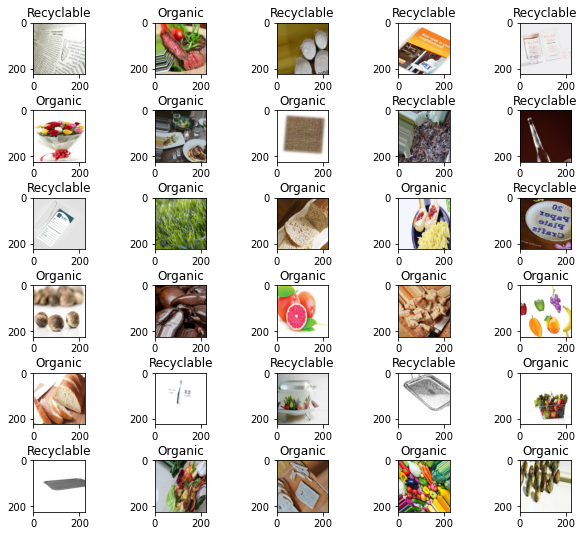

In [26]:
display(sample_batch,sample_label)

### CNN - VGG16 Architeture using Tranfer Learning

**Transfer Learning** can be understood in terms of Domains and Tasks. In our case, the domain is image classification, and our task is to classify objects. If we use a CNN that's already been optimized and trained for a similar domain and task, we could convert it to work with our task which is what transfer learning accomplishes.

We will utilize the pre-trained **VGG16 model**, which is a convolutional neural network trained on 1.2 million images to classify 1000 different categories. Since the domain and task for VGG16 are similar to our domain and task, we can use its pre-trained network for our project. 

**we can't use the entirety of the pre-trained model's architecture. The Fully-Connected layer generates 1,000 different output labels, whereas our Target Dataset has only two classes for prediction. So we'll import a pre-trained model like VGG16, but "cut off" the Fully-Connected layer - also called the "top" model.**

In [27]:
IMAGE_SIZE = [224,224]

In [28]:
# add preprocessing layer to the front of VGG
vgg_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 9s 0us/step


In [30]:
# don't train existing weights
for layer in vgg_model.layers:
    layer.trainable = False

In [32]:
input_shape = (224, 224, 3)

In [38]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**We have imported VGG16 from keras with pre-trained weights which was trained on imagenet. 'include_top' is set to False, in order to exclude the VGG16 model's fully-connected layers (to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable) & ran vgg_model.summary() then the summary of the whole VGG model which was downloaded will be printed.**

In [41]:
from glob import glob
folders = glob('D:/Deakin University (Applied AI (Professional)/SIT744 (Deep Learning)/Tasks & Assignments/Assignment-2/DATASET/TRAIN/*')

In [42]:
# Adding new layers
cnn_model = Flatten()(vgg_model.output)
prediction = Dense(len(folders), activation='softmax')(cnn_model)

In [43]:
# create a model object
finalcnn_model = Model(inputs=vgg_model.input, outputs=prediction)
# view the structure of the model
finalcnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

- We set up a new "top" portion of the model by grabbing the vgg_model outputs and flattening them.

- Since our problem is to detect Recyclable and Organic and it has two classes so the last dense layer of our model should be a 2 unit softmax dense layer in the end. In this way we will remove the last layer of the VGG16 model which is made to predict 1000 classes. 

### Task 2.2 Compare the performance under equal training time

In [50]:
from tensorflow.keras.optimizers import Adam
adamopt = Adam(lr=0.01)
METRICS = ['accuracy',
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall')]

In [51]:
history = finalcnn_model.compile(loss='categorical_crossentropy', 
                                 optimizer= adamopt, 
                                 metrics= METRICS)

**We have set the Metrics in order to calculate model's accuracy, precision & recall after each epoch & learning rate of adam optimzer using 'lr' parameter and since we have a 2 unit dense layer in the end so we will be using 'categorical_crossentropy' as loss since the output of the model is categorical & compiled our model.**

In [52]:
checkpoint = ModelCheckpoint(filepath = 'bestcnn.hdf5', verbose = 1, save_best_only = True)

In [53]:
earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 15, #Number of epochs we wait before stopping 
                          verbose = 1,
                          mode = 'min',
                          restore_best_weights = True) #keeps the best weigths once stopped

In [54]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, verbose=2,
                              mode='max')

In [55]:
callbacks = [earlystop, checkpoint, lr_reduce]

- **checkpoint**: ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
- **earlystop**: Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. It basically stops training when a monitored metric has stopped improving.
- **lr_reduce**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
- **Later, we saved EarlyStopping, ModelCheckpoint & ReduceLROnPlateau in callbacks.**

In [56]:
modelhist = finalcnn_model.fit_generator(train_dset,
                                         epochs= 20,
                                         verbose= 1,
                                         validation_data= val_dset,
                                         callbacks= callbacks)

Epoch 1/20
565/565 [==============================] - 2441s 4s/step - loss: 2.4004 - accuracy: 0.8169 - precision: 0.8169 - recall: 0.8169 - val_loss: 2.3963 - val_accuracy: 0.8484 - val_precision: 0.8484 - val_recall: 0.8484

Epoch 00001: val_loss improved from inf to 2.39634, saving model to bestcnn.hdf5
Epoch 2/20
565/565 [==============================] - 2517s 4s/step - loss: 2.7577 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - val_loss: 2.5691 - val_accuracy: 0.8579 - val_precision: 0.8579 - val_recall: 0.8579

Epoch 00002: val_loss did not improve from 2.39634
Epoch 3/20
565/565 [==============================] - 2492s 4s/step - loss: 2.6099 - accuracy: 0.8570 - precision: 0.8570 - recall: 0.8570 - val_loss: 2.8565 - val_accuracy: 0.8280 - val_precision: 0.8280 - val_recall: 0.8280

Epoch 00003: val_loss did not improve from 2.39634
Epoch 4/20
565/565 [==============================] - 2494s 4s/step - loss: 2.9272 - accuracy: 0.8562 - precision: 0.8562 - recall: 0.85

**We are using model.fit_generator as we have used ImageDataGenerator to pass data to the model. We will pass train and validation data to fit_generator. We have fitted where we provided the training set, number of epochs, verbose for model information, validation set & callbacks. As we have trained our model on 20 epochs, we can see the performance metrics related to each epoch.**

Now, we will visualize the model's performance using matplotlib & we can see our training accuracy increased overtime while the validation loss decreased: 

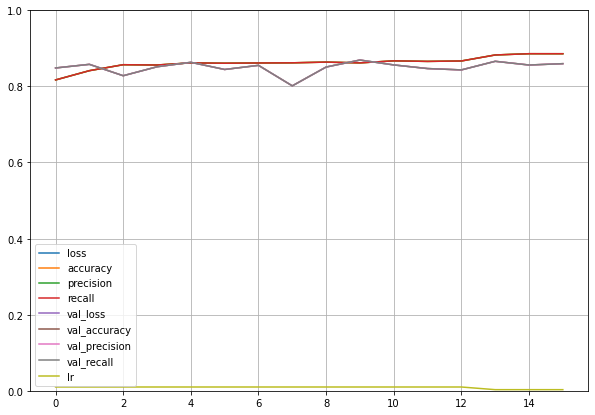

In [58]:
pd.DataFrame(modelhist.history).plot(figsize = (10,7))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.show()

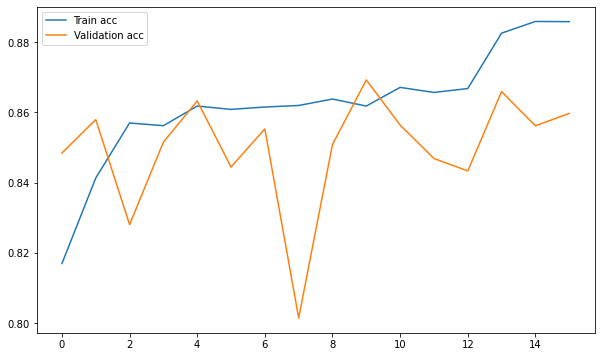

In [59]:
plt.figure(figsize=[10,6])
plt.plot(modelhist.history["accuracy"], label = "Train acc")
plt.plot(modelhist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

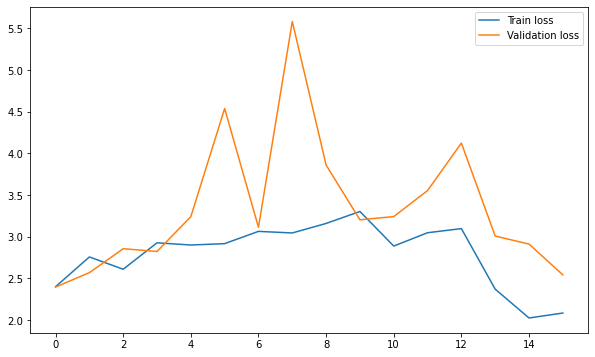

In [60]:
plt.figure(figsize=(10,6))
plt.plot(modelhist.history['loss'], label = "Train loss")
plt.plot(modelhist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

**Structure of our model:**

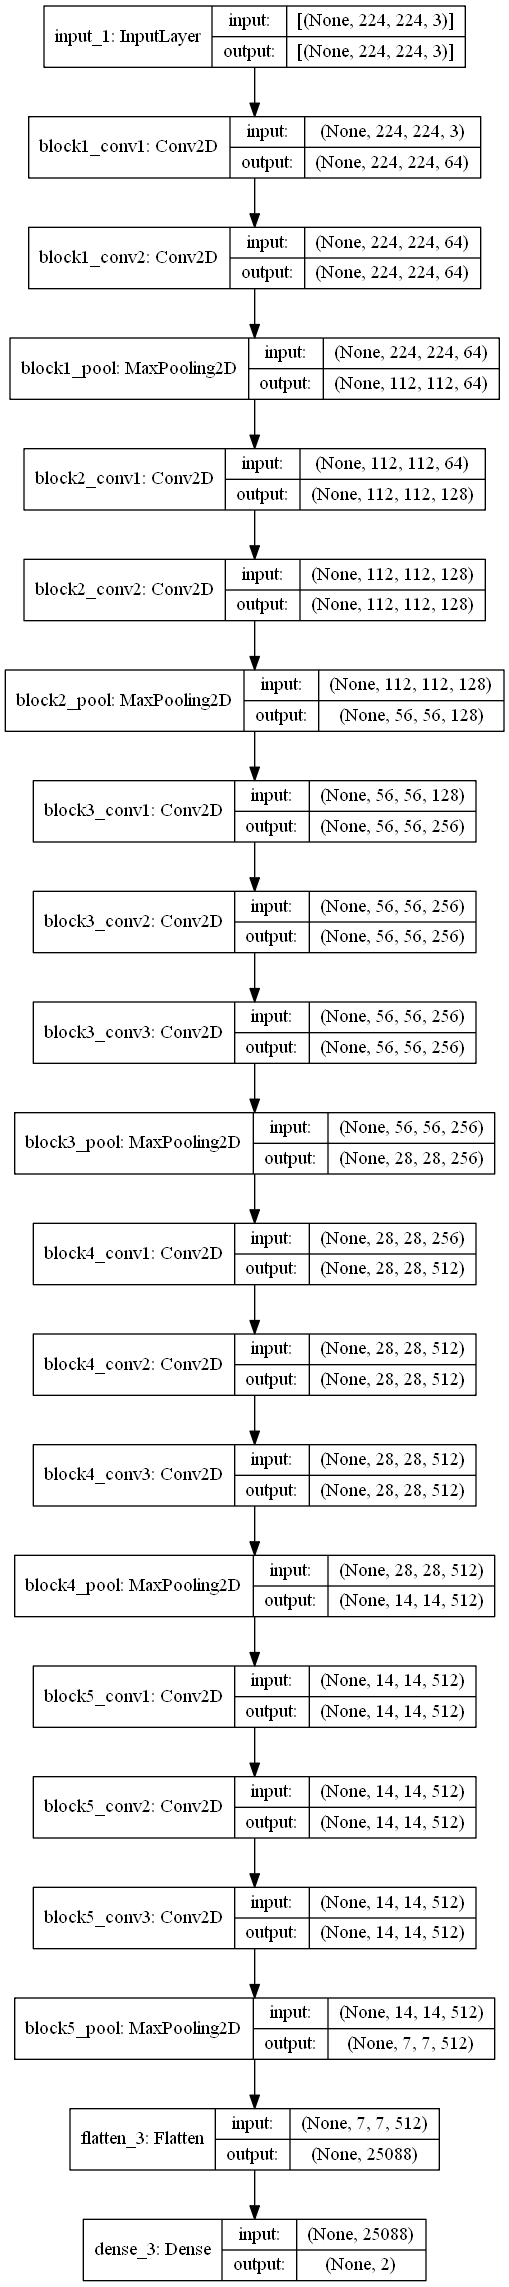

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(finalcnn_model, show_shapes=True)

### Test Accuracy


In [67]:
# Score
score = finalcnn_model.evaluate(test_dset, verbose=0)
print('Test Loss', score[0])
print('Test accuracy', score[1])

Test Loss 2.4015157222747803
Test accuracy 0.8587346076965332


**Our model performed pretty well with an accuracy of 85.8% on the test set while giving loss of 2.4.**

**Now we will check & visualize the predictions using the test set:** 

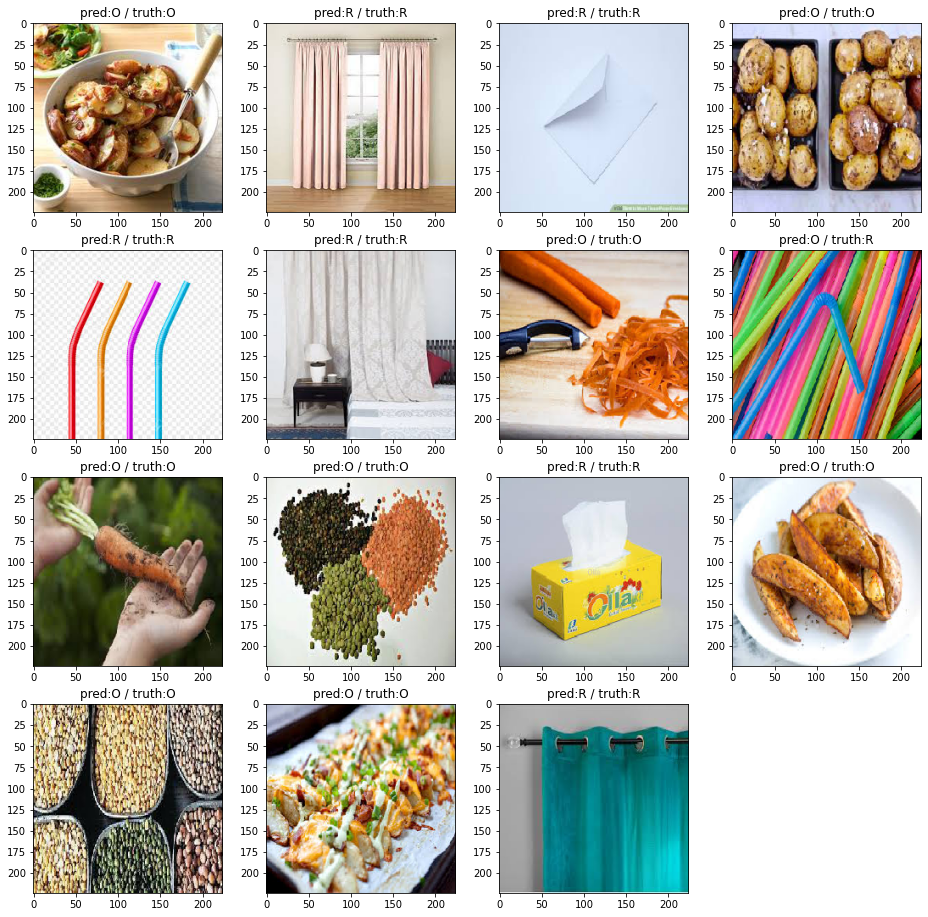

In [64]:
test_x, test_y = test_dset.__getitem__(1)

labels = (test_dset.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = finalcnn_model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [69]:
finalcnn_model.save('newbestcnn.h5')

**We have saved our model**

In [70]:
import pickle

pickle_out = open("Trained_cnn_history.pickle","wb")
pickle.dump(modelhist.history, pickle_out)
pickle_out.close()

In [71]:
pickle_in = open("Trained_cnn_history.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

{'loss': [2.4004242420196533, 2.7577390670776367, 2.6098623275756836, 2.9271738529205322, 2.9008262157440186, 2.9173710346221924, 3.0644636154174805, 3.045546054840088, 3.159682035446167, 3.3031649589538574, 2.8881921768188477, 3.0482215881347656, 3.0977463722229004, 2.370828151702881, 2.0250916481018066, 2.0842676162719727], 'accuracy': [0.8169177770614624, 0.8412918448448181, 0.8569687604904175, 0.8561932444572449, 0.8617881536483765, 0.8608464598655701, 0.8615111708641052, 0.8619543313980103, 0.8637824058532715, 0.8617881536483765, 0.8671061396598816, 0.865665853023529, 0.866773784160614, 0.8825615048408508, 0.8858852386474609, 0.8858298063278198], 'precision': [0.8169177770614624, 0.8412918448448181, 0.8569687604904175, 0.8561932444572449, 0.8617881536483765, 0.8608464598655701, 0.8615111708641052, 0.8619543313980103, 0.8637824058532715, 0.8617881536483765, 0.8671061396598816, 0.865665853023529, 0.866773784160614, 0.8825615048408508, 0.8858852386474609, 0.8858298063278198], 'recall

In [74]:
preds = np.argmax(preds, axis=1)

### Task 2.3 Identifying model strength and weakness

In [95]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [97]:
target_names = []
for key in train_dset.class_indices:
    target_names.append(key)

In [98]:
print(target_names)

['O', 'R']


Confusion Matrix
Normalized confusion matrix


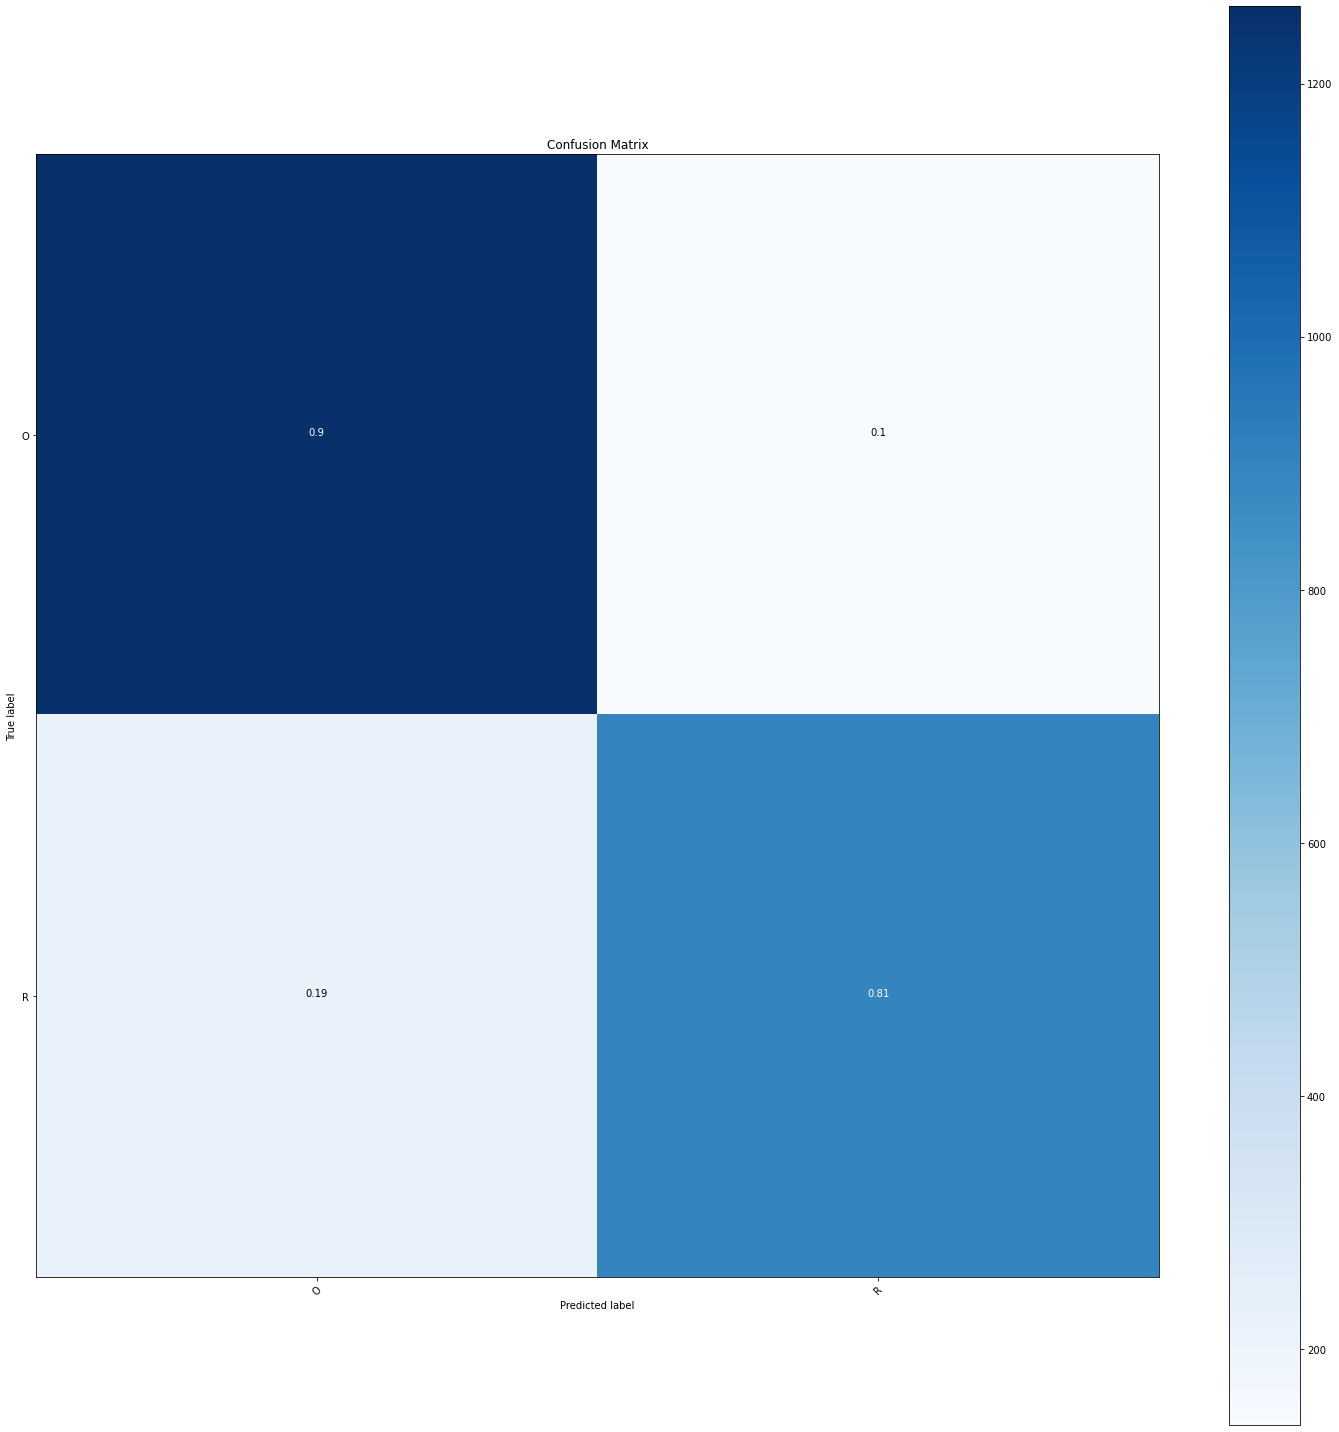

In [99]:
Y_pred = finalcnn_model.predict_generator(test_dset)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_dset.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [101]:
#Print Classification Report
from sklearn.metrics import classification_report

print('Classification Report')
print(classification_report(test_dset.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           O       0.85      0.90      0.88      1401
           R       0.86      0.81      0.83      1112

    accuracy                           0.86      2513
   macro avg       0.86      0.85      0.86      2513
weighted avg       0.86      0.86      0.86      2513



- We have used a normalized confusion matrix as the difference between a normalized and unnormalized confusion matrix arises due to an imbalance in classes. The “normalized” term means that each of these groupings is represented as having 1.00 samples. Thus, the sum of each row in a balanced and normalized confusion matrix is 1.00, because each row sum represents 100% of the elements in a particular topic, cluster, or class. 
- Not all classes have the same number of total samples, and thus the unnormalized matrix outputs the absolute value, without considering how much proportion of the total class size is predicted correctly, which leads to improper conclusions due to the colorization of the heatmap.
- We can see that the model classified 90% of the data correctly while giving 10% misclassification for class 0 (Organic)  & the model classified 81% of the data correctly while giving 19% misclassification for class 1 (Recyclable).
- The accuracy of the model is quite good, from the weighted average: the model is 86% precise with recall 0.86 and f1-score of 0.86.

## **Task 3 (D Task) Improve model generalisability across domains**

Now, we will test our model on a new dataset with different objects & see how it performs on unseen data:

In [102]:
# Newly collected test data
newtest_p = "D:/Deakin University (Applied AI (Professional)/SIT744 (Deep Learning)/Tasks & Assignments/Assignment-2/NEWTEST"

In [103]:
newtest_dset = test_dgen.flow_from_directory(newtest_p, 
                                          class_mode = 'categorical',
                                          batch_size = 32, 
                                          target_size=(224, 224),
                                          shuffle=False,)

Found 1700 images belonging to 2 classes.


In [104]:
# Model evaluation of New Test Data
score2 = finalcnn_model.evaluate(newtest_dset, verbose=0)
print('Test Loss', score2[0])
print('Test accuracy', score2[1])

Test Loss 1.792481780052185
Test accuracy 0.8617647290229797


**Our model performed well on a new dataset with a test accuracy of 86% & loss of 1.7.**


**We have displayed the predictions on the new test dataset:**

In [105]:
newci = newtest_dset.class_indices

In [106]:
newci

{'O': 0, 'R': 1}

In [107]:
for nsample_batch,nsample_label in newtest_dset:
    print(nsample_batch.shape)
    print(nsample_label.shape)
    break

(32, 224, 224, 3)
(32, 2)


In [108]:
nclass_names=['Organic','Recyclable']

In [109]:
def ndisplay(nimg_batch,nlabel_batch):
    plt.figure(figsize=(10,9))
    plt.subplots_adjust(wspace=0.7,hspace=0.7)
    for i in range(30):
        plt.subplot(6,5,i+1)
        plt.imshow(nimg_batch[i])
        plt.title(nclass_names[np.argmax(nlabel_batch[i])])

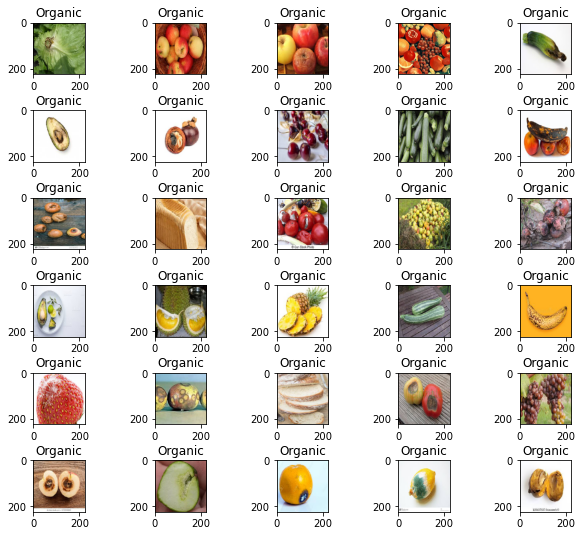

In [110]:
ndisplay(nsample_batch,nsample_label)

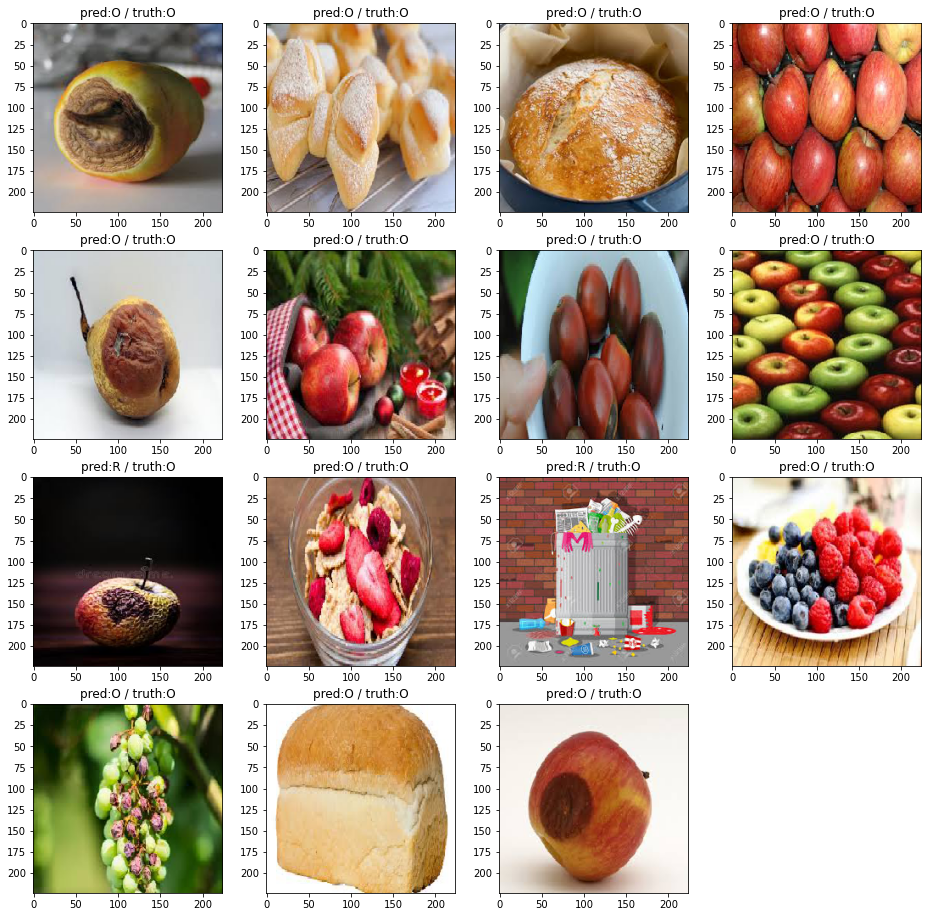

In [111]:
ntest_x, ntest_y = newtest_dset.__getitem__(1)

nlabels = (newtest_dset.class_indices)
nlabels = dict((v,k) for k,v in nlabels.items())

npreds = finalcnn_model.predict(ntest_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (nlabels[np.argmax(npreds[i])], nlabels[np.argmax(ntest_y[i])]))
    plt.imshow(ntest_x[i])

In [120]:
tf.keras.models.save_model(finalcnn_model, 'mynewbestcnn.hdf5')

### Improving the Model

We will be using ResNet-50, a convolutional neural network that is 50 layers deep. We will load a pretrained version of the network that is trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories. The network has an image input size of 224x224. This architecture will reduce the loss & increase the accuracy of our model.

### Using Resnet50 Architecture

In [179]:
# Importing the Resnet50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

resnet2 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [180]:
x2 = Flatten()(resnet2.output)
prediction2 = Dense(len(folders), activation='softmax')(x2)
newcnn_model2 = Model(inputs=resnet2.input, outputs=prediction2)

In [181]:
newcnn_model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [182]:
adamopt2 = Adam(lr=0.002)

history2 = newcnn_model2.compile(optimizer= adamopt2,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

In [185]:
#fit the model
modelhist2 = newcnn_model2.fit_generator(train_dset,
                                         epochs= 5,
                                         verbose= 1,
                                         validation_data= val_dset,
                                         steps_per_epoch=len(train_dset),
                                         validation_steps=len(val_dset))

Epoch 1/5
565/565 [==============================] - 3888s 7s/step - loss: 1.9686 - accuracy: 0.7034 - val_loss: 1.6570 - val_accuracy: 0.4430
Epoch 2/5
565/565 [==============================] - 3875s 7s/step - loss: 0.5162 - accuracy: 0.8016 - val_loss: 0.4210 - val_accuracy: 0.8231
Epoch 3/5
565/565 [==============================] - 3889s 7s/step - loss: 0.5294 - accuracy: 0.8012 - val_loss: 0.8585 - val_accuracy: 0.7626
Epoch 4/5
565/565 [==============================] - 3919s 7s/step - loss: 0.4699 - accuracy: 0.8175 - val_loss: 0.5644 - val_accuracy: 0.7693
Epoch 5/5
565/565 [==============================] - 3938s 7s/step - loss: 0.5426 - accuracy: 0.8060 - val_loss: 6.4591 - val_accuracy: 0.4814


2022-05-18 18:28:39.985 t=2022-05-18T18:28:39+0530 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=d18c5560a017 err="read tcp 192.168.1.11:50341->3.16.250.205:443: wsarecv: An existing connection was forcibly closed by the remote host."
2022-05-18 18:28:40.760 t=2022-05-18T18:28:40+0530 lvl=info msg="tunnel session started" obj=tunnels.session
2022-05-18 18:28:41.812 t=2022-05-18T18:28:41+0530 lvl=info msg="client session established" obj=csess id=d18c5560a017
2022-05-18 18:28:44.470 t=2022-05-18T18:28:44+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=3dda466d5cfd clientid=ffa171a9307fbdbeef7b6564b6a731db
2022-05-18 18:38:57.095 t=2022-05-18T18:38:57+0530 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=d18c5560a017 err="read tcp 192.168.1.11:55978->3.134.73.173:443: wsarecv: An established connection was aborted by the software in your host machine."
2022-05-18 18:38:57.999 t=2022-05-18T18:38:57+0530 lvl=info msg="tunnel 

**As we can conclude that using this model we can achieve better accuracy for more number of epochs as we have already achieved an accuracy of 80.6% & loss of 0.54 which is pretty great. Data is sufficiently large , therefore the model doesn't overfit for small number of epochs and generalizes well.**

## **Task 4 (HD Task) Build a workable prototype**

**Now we will build a working prototype for our image classification as a web application using streamlit:**

In [119]:
!pip install streamlit

  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13451 sha256=b560115954d3b5b3e3c07f485dbc8345bc4ad0ff98940ff87af7c197584975b9
  Stored in directory: c:\users\rahul\appdata\local\pip\cache\wheels\b7\a5\68\fe632054a5eadd531c7a49d740c50eb6adfbeca822b4eab8d4
  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19538 sha256=ff99bfce5cea3337db6348e6b19565b26c19f34be4a09d150f9cfba357a3ca0b
  Stored in directory: c:\users\rahul\appdata\local\pip\cache\wheels\44\50\f0\cb4b5b437aa8bb1f8417c877b27b0722d3f6b5f72f744fc8a3
Successfully built blinker validators


We will now load the saved model:

In [155]:
model = load_model('D:/Deakin University (Applied AI (Professional)/SIT744 (Deep Learning)/Tasks & Assignments/Assignment-2/mynewbestcnn.hdf5')

We will now write the frontend of our application (how the webpage will look like):

In [160]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st

st.write("""
         # Intelligent Waste Classification System
         """
         )
st.write("This is a simple image classification web app to predict whther an object is Recyclable or not")
file = st.file_uploader("Please upload an image file", type=["jpg", "png"])

import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
    
        size = (224,224)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img_resize[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, model)
    
    if np.argmax(prediction) == 0:
        st.write("It is Organic!")
    else:
        st.write("It is Recyclable")
    
    st.text("Probability (0: Organic, 1: Recyclable")
    st.write(prediction)

Overwriting app.py


In [162]:
!ngrok authtoken 29IOmLgRTeaUoM2mA0uLzjezFlB_s4zgExgTw9PwtHxt8o2C

Authtoken saved to configuration file: C:\Users\Rahul/.ngrok2/ngrok.yml


In [170]:
get_ipython().system_raw('./ngrok http 8501 &')

In [173]:
!streamlit run app.py

^C


**Due to some technical issues, the prototype isn't working but due to time constraint I'll be submitting the Assignment-2 & will further work on this project to make the protoype workable as a web application or a mobile application. Thank you.**